In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [2]:
breast_cancer_df = pd.read_pickle("wdbc.pkl")

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(breast_cancer_df.drop(columns=["malignant", "id"]), breast_cancer_df["malignant"], test_size=0.2, random_state=10)
X_column_names = list(X_train_df.columns)

print(X_column_names)

['radius_0', 'texture_0', 'perimeter_0', 'area_0', 'smoothness_0', 'compactness_0', 'concavity_0', 'concave points_0', 'symmetry_0', 'fractal dimension_0', 'radius_1', 'texture_1', 'perimeter_1', 'area_1', 'smoothness_1', 'compactness_1', 'concavity_1', 'concave points_1', 'symmetry_1', 'fractal dimension_1', 'radius_2', 'texture_2', 'perimeter_2', 'area_2', 'smoothness_2', 'compactness_2', 'concavity_2', 'concave points_2', 'symmetry_2', 'fractal dimension_2']


In [3]:
malignant_df = X_train_df[y_train_df == 1]
benign_df = X_train_df[y_train_df == 0]
print(malignant_df.shape)
print(benign_df.shape)

malignant_mean = malignant_df.mean().to_numpy()
malignant_var = malignant_df.var().to_numpy()
malignant_std = malignant_df.std().to_numpy()

benign_mean = benign_df.mean().to_numpy()
benign_var = benign_df.var().to_numpy()
benign_std = benign_df.std().to_numpy()

(173, 30)
(282, 30)


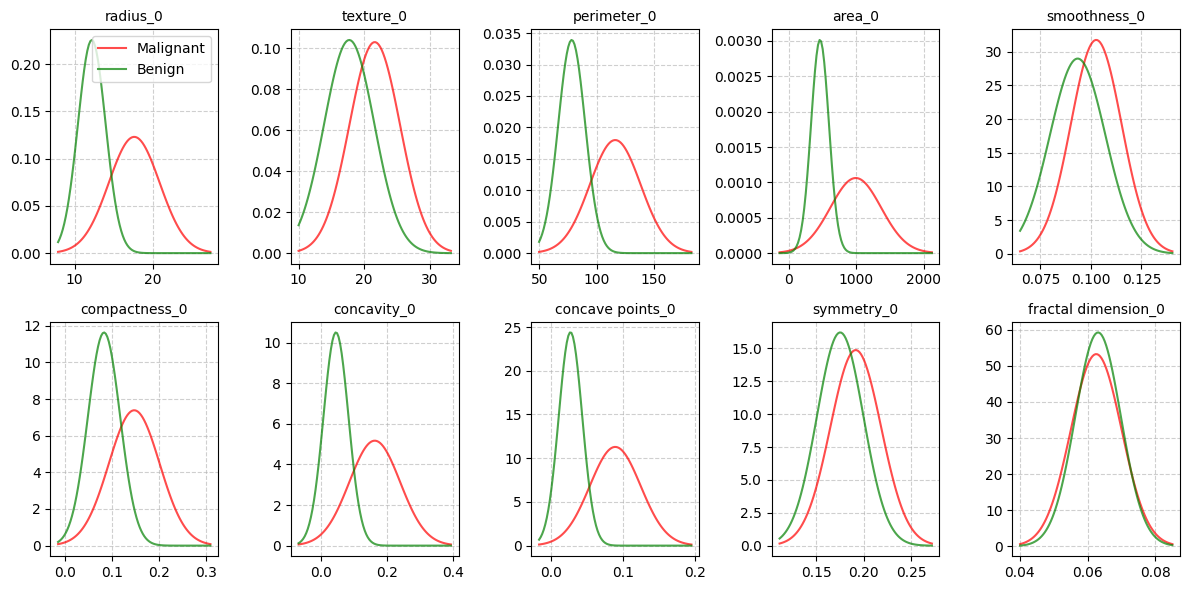

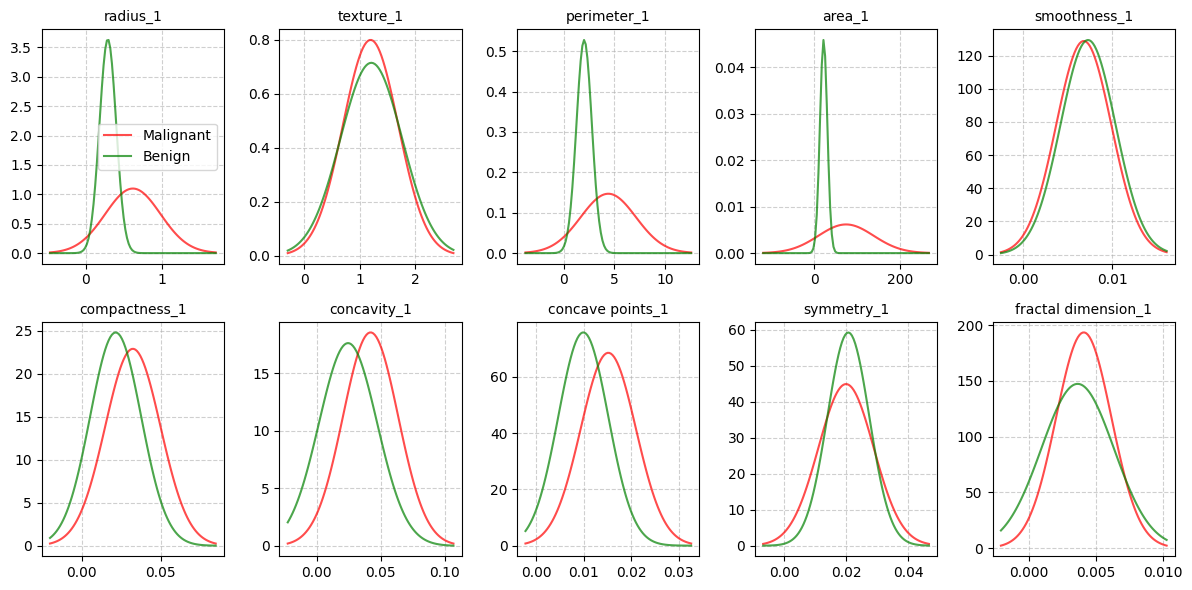

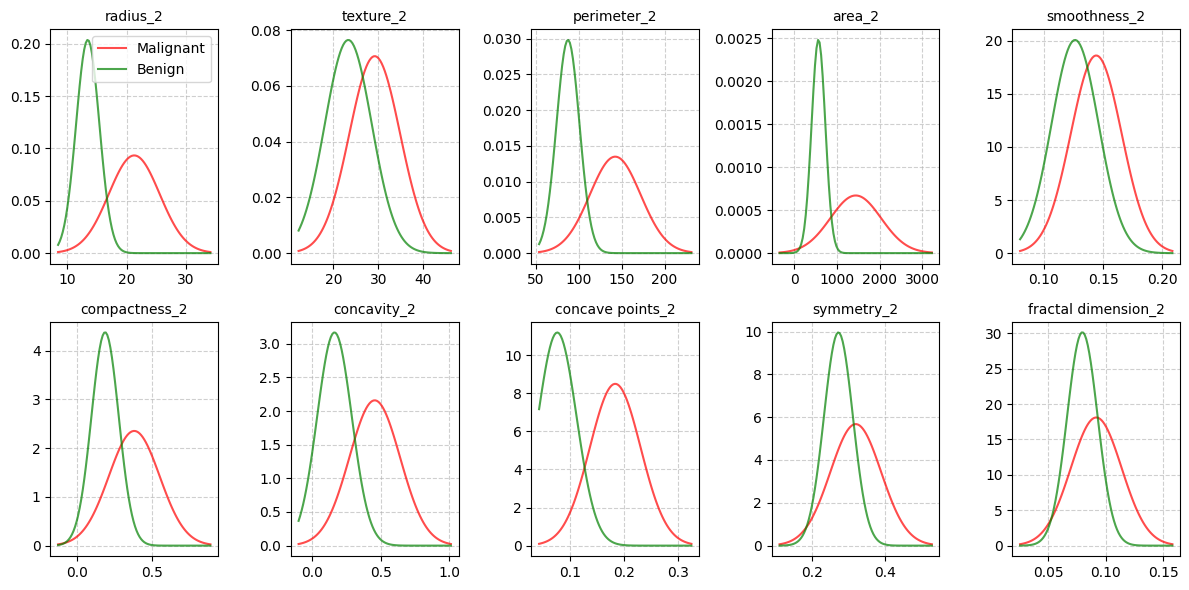

In [4]:
feature_groups = [(0, 10),  (10, 20), (20, 30)]

for group_id, (start, end) in enumerate(feature_groups):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
    axes = axes.flatten()
    
    for i, feature_id in enumerate(range(start, end)):
        ax = axes[i]
        ax.grid(True, linestyle="--", alpha=0.6)
        x = np.linspace(malignant_mean[feature_id] - 3*malignant_std[feature_id],
                        malignant_mean[feature_id] + 3*malignant_std[feature_id], 100)
        
        ax.plot(x, norm.pdf(x, malignant_mean[feature_id], malignant_std[feature_id]), label="Malignant", alpha=0.7, color="red")
        ax.plot(x, norm.pdf(x, benign_mean[feature_id], benign_std[feature_id]), label="Benign", alpha=0.7, color="green")
        
        ax.set_title(X_column_names[feature_id], fontsize=10)
    
    axes[0].legend()  # index for legend, can be put on all tiny plots
    plt.tight_layout()
    plt.show()

Accuracy: 0.8947368421052632
Recall: 0.9487179487179487
Precision: 0.7872340425531915
F1: 0.8604651162790697


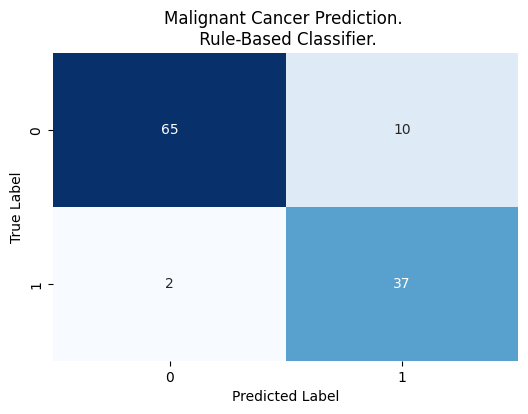

In [5]:
## the rule based classifier
def cell_size_abnormal(sample):
    #radius, perimeter, area
    return sample['radius_2'] >= 19 or sample['area_2'] >= 1000 or sample['area_1'] >= 50 or sample['perimeter_2'] >= 130

def cell_shape_abnormal(sample):
    #smoothness, compactness, concavity, concave
    return sample["concavity_2"] >= 0.6 or sample["concave points_2"] >= 0.17  or sample["compactness_2"] >= 0.45

def cell_texture_abnormal(sample):
    # texture, fractal dimension
    return sample["texture_2"] >= 38 or sample["fractal dimension_2"] >= 0.125 or sample["smoothness_2"] >= 0.17

def cell_homogenity_abnormal(sample):
    #symmetry
    return sample["symmetry_2"] >= 0.36

def rule_based_classifier(X_df):
    y_pred = []
    for _, row in X_df.iterrows():
        if cell_size_abnormal(row):
            y_pred.append(1)
        elif cell_shape_abnormal(row):
            y_pred.append(1)
        elif cell_texture_abnormal(row):
            y_pred.append(1)
        elif cell_homogenity_abnormal(row):
            y_pred.append(1)
        else:
            y_pred.append(0)

    return np.array(y_pred)

y_test_labels = y_test_df.to_numpy()
y_test_pred = rule_based_classifier(X_test_df)

print(f"Accuracy: {accuracy_score(y_test_labels, y_test_pred)}")
print(f"Recall: {recall_score(y_test_labels, y_test_pred)}")
print(f"Precision: {precision_score(y_test_labels, y_test_pred)}")
print(f"F1: {f1_score(y_test_labels, y_test_pred)}")

cm = confusion_matrix(y_test_labels, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Malignant Cancer Prediction. \n Rule-Based Classifier.")
plt.show()


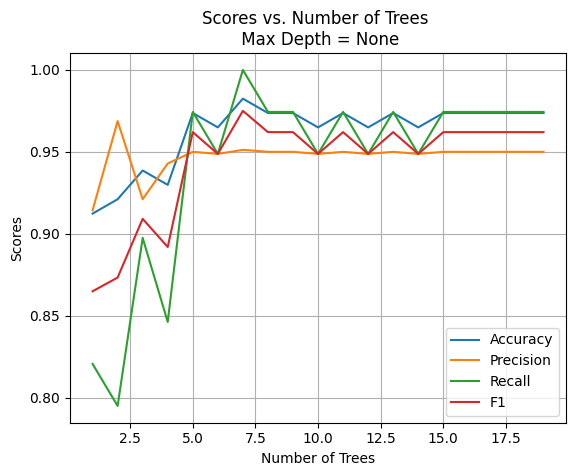

In [10]:
n_trees = np.arange(1, 20, 1)

accuracy = []
recall = []
precision = []
f1 = []

for n in n_trees:
    random_forest_classifier = RandomForestClassifier(n_estimators=n, random_state=10, max_depth=None)
    random_forest_classifier.fit(X_train_df.copy(), y_train_df.copy())
    y_pred_RF = random_forest_classifier.predict(X_test_df.copy())

    accuracy.append(accuracy_score(y_test_labels, y_pred_RF))
    recall.append(recall_score(y_test_labels, y_pred_RF))
    precision.append(precision_score(y_test_labels, y_pred_RF))
    f1.append(f1_score(y_test_labels, y_pred_RF))

plt.plot(n_trees, accuracy, label="Accuracy")
plt.plot(n_trees, precision, label="Precision")
plt.plot(n_trees, recall, label="Recall")
plt.plot(n_trees, f1, label="F1")

plt.xlabel("Number of Trees")
plt.ylabel("Scores")
plt.title("Scores vs. Number of Trees \n Max Depth = None")
plt.legend()
plt.grid(True)
plt.show()

Accuracy: 0.9912280701754386
Recall: 1.0
Precision: 0.975
F1: 0.9873417721518988


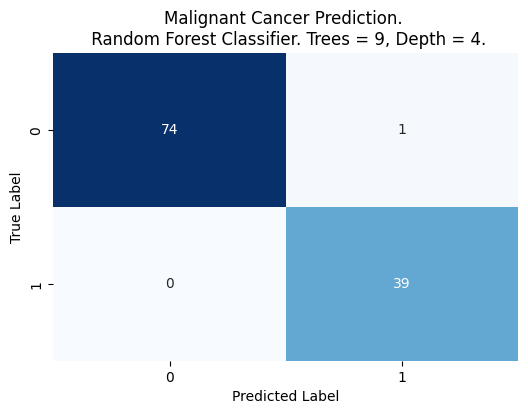

In [11]:
n_tree = 9
depth = 4
random_forest_classifier = RandomForestClassifier(n_estimators= n_tree, random_state=10, max_depth=depth)

random_forest_classifier.fit(X_train_df, y_train_df)

y_pred_RF = random_forest_classifier.predict(X_test_df)

print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_RF)}")
print(f"Recall: {recall_score(y_test_labels, y_pred_RF)}")
print(f"Precision: {precision_score(y_test_labels, y_pred_RF)}")
print(f"F1: {f1_score(y_test_labels, y_pred_RF)}")

cm = confusion_matrix(y_test_labels, y_pred_RF)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Malignant Cancer Prediction. \n Random Forest Classifier. Trees = {n_tree}, Depth = {depth}.")
plt.show()

In [8]:
'''#THIS CODE REQUIRES YOU TO DOWNLOAD AND INSTALL GRAPHVIZ LOCALLY
from sklearn.tree import export_graphviz
import graphviz
for i in range(0,1):
    tree = random_forest_classifier.estimators_[i]
    dot_data = export_graphviz(tree,
                           feature_names=X_train_df.columns, class_names=["Benign", "Malignant"],  
                           filled=True, max_depth=None, 
                           impurity=False, proportion=False, special_characters=True) 
    graph = graphviz.Source(dot_data)
    display(graph)
'''

'#THIS CODE REQUIRES YOU TO DOWNLOAD AND INSTALL GRAPHVIZ LOCALLY\nfrom sklearn.tree import export_graphviz\nimport graphviz\nfor i in range(0,1):\n    tree = random_forest_classifier.estimators_[i]\n    dot_data = export_graphviz(tree,\n                           feature_names=X_train_df.columns, class_names=["Benign", "Malignant"],  \n                           filled=True, max_depth=None, \n                           impurity=False, proportion=False, special_characters=True) \n    graph = graphviz.Source(dot_data)\n    display(graph)\n'